## LAB con Ioannis 22/11

In [12]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import os
from scipy import stats

In [13]:
data = pd.read_csv('/Users/simonefacchiano/Desktop/Data Science/ADM/ADM HW4/bank_transactions.csv')

In [14]:
data.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


### Data Cleaning

In [15]:
data.info()

# We need to convert the DateOfBirth and the TransactionData as date objects, same for TransactionTime

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


In [16]:
# We rename the last column to simplify:

data.rename(columns = {'TransactionAmount (INR)':'TransactionAmount'}, inplace = True)

### Missing values

In [17]:
print(data.isna().sum())
print('*********************************')
print('*********************************')
print('The total number of rows is: ',len(data))

TransactionID            0
CustomerID               0
CustomerDOB           3397
CustGender            1100
CustLocation           151
CustAccountBalance    2369
TransactionDate          0
TransactionTime          0
TransactionAmount        0
dtype: int64
*********************************
*********************************
The total number of rows is:  1048567


Since the number of NaN's is pretty low, we can drop the rows containing missing values:

In [18]:
data.dropna(inplace = True) # tanto sono poche

In [19]:
print(data.columns)

data[['CustAccountBalance', 'TransactionAmount']].describe()

Index(['TransactionID', 'CustomerID', 'CustomerDOB', 'CustGender',
       'CustLocation', 'CustAccountBalance', 'TransactionDate',
       'TransactionTime', 'TransactionAmount'],
      dtype='object')


,CustAccountBalance,TransactionAmount
count,1.041614e+06,1.041614e+06
mean,1.149986e+05,1.566096e+03
std,8.467609e+05,6.561464e+03
min,0.000000e+00,0.000000e+00
25%,4.728140e+03,1.600000e+02
50%,1.676852e+04,4.575000e+02
75%,5.742885e+04,1.200000e+03
max,1.150355e+08,1.560035e+06


There are Transactions of 0! This makes no sense, so we want to delete them:

In [20]:
data = data[data['TransactionAmount'] != 0]

In [21]:
# I want to know if CustomerID has some repetead values:
print(data['CustomerID'].nunique())
print(len(data))
print('There are', len(data) - data['CustomerID'].nunique(), 'values that are present more than one time')

878763
1040794
There are 162031 values that are present more than one time


### Date

In [22]:
# We want to convert DateOfBirth, TransactionDate and TransactionTime in a datetime format

data.dropna(inplace=True)
data.CustomerDOB = pd.to_datetime(data.CustomerDOB) 
data.TransactionDate = pd.to_datetime(data.TransactionDate) 
#data.TransactionTime = data.TransactionTime.apply(lambda x: datetime.strptime(str(x).zfill(6), '%H%M%S'))
data.TransactionTime = pd.to_datetime(data.TransactionTime) 

<AxesSubplot:>

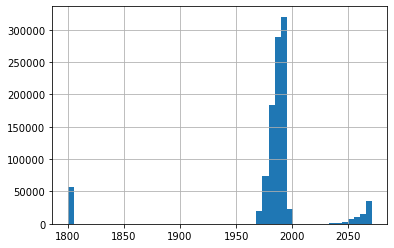

In [23]:
data.CustomerDOB.dt.year.hist(bins = 50)

In [24]:
# This is obviously very strange, but let's see:
print('Years of births are up to', max(data.CustomerDOB.dt.year))

print('For people born in the XX century, dates start from', min(data['CustomerDOB'][data.CustomerDOB.dt.year > 1850]))

# Therefore, it would appear that people born before 1972 were reported as born after 2000. 

Years of births are up to 2071
For people born in the XX century, dates start from 1972-01-01 00:00:00


<AxesSubplot:>

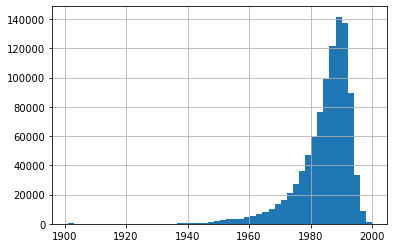

In [25]:
# To fix this error, we execute:
data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)

# Then, we remove observations from 1800's:
data.drop(data[data.CustomerDOB.dt.year <= 1805].index, axis = 0, inplace = True)

# and finally we have:
data.CustomerDOB.dt.year.hist(bins = 50)

In [26]:
# Now, we have some data regardin the early 1900's, while the life expectancy at birth in India is 69 years for women and 68 years for men. Somethins is not working... Also, see how the shape of the histogram abruptly stops at the beginning of the new millennium. Making similar reasoning to that seen above:

print('Years of births stops in', max(data.CustomerDOB.dt.year), '...')
print('But note that we have some very early observstions, starting from', min(data['CustomerDOB'][data.CustomerDOB.dt.year < 1915]), '!')
print('So, we move those observations like we did before!')

Years of births stops in 2000 ...
But note that we have some very early observstions, starting from 1901-01-01 00:00:00 !
So, we move those observations like we did before!


<BarContainer object of 16 artists>

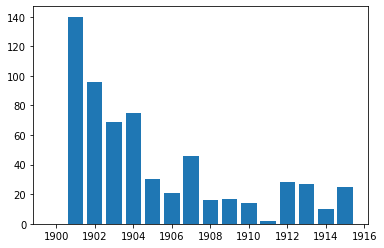

In [27]:
years = []
number = []
for i in range(1900, 1916):
    years.append(i)
    number.append(len(data[data.CustomerDOB.dt.year == i]))

plt.bar(years, number)

# sembrerebbe che fino al 1906 ci siano degli errori, e guarda caso in india sopra i 10 anni puoi aprire un conto! quindi ha senso che ci siano persone nate tra il 2000 e il 2006!

This trend makes us think that there are probably errors here as well....
The number of people born at the beginning of the last century declines, until it reaches a low in 1906, and then begins to rise again.
This leads us to think that perhaps the observations of people born between 1900 and 1906 are actually referring to the 2000s

In [28]:
data.loc[data.CustomerDOB.dt.year <= 1906, 'CustomerDOB'] = data.loc[data.CustomerDOB.dt.year <= 1906, 'CustomerDOB'] + pd.DateOffset(years = 100)

<AxesSubplot:>

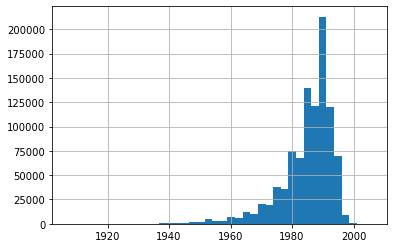

In [29]:
# Now the distribution of age looks like this:
data.CustomerDOB.dt.year.hist(bins = 40)

In [33]:
print('The youngest customer in our dataset was born in:', max(data.CustomerDOB))
print('So, he/she is', 2016 - max(data.CustomerDOB.dt.year), '!')

The youngest customer in our dataset was born in: 2006-08-11 00:00:00
So, he/she is 10 !


This makes perfect sense!
In fact, the dataset we are working on is from 2016. The youngest people among those registered are 10 years old, and in India the minimum age to open a bank account is precisely 10 years old!
This leads us to believe that our analysis is correct

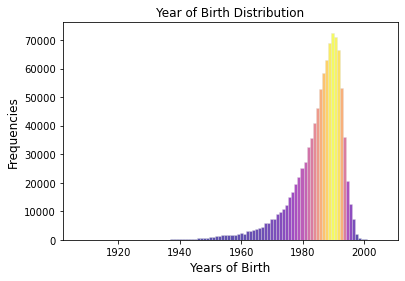

In [7]:
# Now the distribution of age looks like this (with a nicer plot):

n, bins, patches = plt.hist(data.CustomerDOB.dt.year, bins=100, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)

n = n.astype('int') # it MUST be integer
# Good old loop. Choose colormap of your taste
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.plasma(n[i]/max(n)))

plt.title('Year of Birth Distribution', fontsize=12)
plt.xlabel('Years of Birth', fontsize=12)
plt.ylabel('Frequencies', fontsize=12)
plt.show()

### Transactions

<AxesSubplot:ylabel='Frequency'>

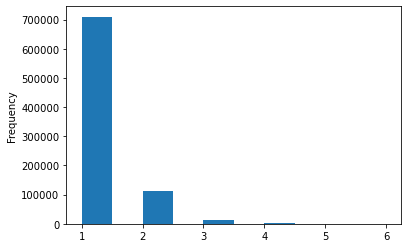

In [148]:
data.groupby('CustomerID').TransactionID.count().plot.hist()

### Age

In [16]:
data['CustomerAge'] = (round((pd.to_datetime('today') - data.CustomerDOB)/np.timedelta64(1, 'Y'), 0)).astype(int)
data.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount,CustomerAge
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,1900-01-01 14:32:07,25.0,28
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,1900-01-01 14:18:58,27999.0,66
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,1900-01-01 14:27:12,459.0,26
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,1900-01-01 14:27:14,2060.0,49
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,1900-01-01 18:11:56,1762.5,35


In [118]:
data['CustomerAge'].nunique()

98

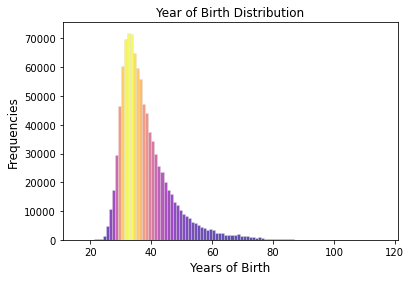

In [150]:
n, bins, patches = plt.hist(data.CustomerAge, bins=100, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)

n = n.astype('int') # it MUST be integer

for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.plasma(n[i]/max(n)))

plt.title('Year of Birth Distribution', fontsize=12)
plt.xlabel('Years of Birth', fontsize=12)
plt.ylabel('Frequencies', fontsize=12)
plt.show()

# This distribution seems reasonable, since the average age in India is 29! 
# https://www.worlddata.info/average-age.php

In [151]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 984614 entries, 0 to 1048566
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   TransactionID       984614 non-null  object        
 1   CustomerID          984614 non-null  object        
 2   CustomerDOB         984614 non-null  datetime64[ns]
 3   CustGender          984614 non-null  object        
 4   CustLocation        984614 non-null  object        
 5   CustAccountBalance  984614 non-null  float64       
 6   TransactionDate     984614 non-null  datetime64[ns]
 7   TransactionTime     984614 non-null  datetime64[ns]
 8   TransactionAmount   984614 non-null  float64       
 9   CustomerAge         984614 non-null  int64         
dtypes: datetime64[ns](3), float64(2), int64(1), object(4)
memory usage: 82.6+ MB


In [17]:
# Now we save it, to simplify the loading for the next runs

data.to_csv('/Users/simonefacchiano/Desktop/Data Science/ADM/ADM HW4/data.csv') 

# 2. Grouping customers together!

## 2.1 Getting your data + feature engineering

In [3]:
data = pd.read_csv('/Users/simonefacchiano/Desktop/Data Science/ADM/ADM HW4/data.csv')
data = data.drop('Unnamed: 0', axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984614 entries, 0 to 984613
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   TransactionID       984614 non-null  object 
 1   CustomerID          984614 non-null  object 
 2   CustomerDOB         984614 non-null  object 
 3   CustGender          984614 non-null  object 
 4   CustLocation        984614 non-null  object 
 5   CustAccountBalance  984614 non-null  float64
 6   TransactionDate     984614 non-null  object 
 7   TransactionTime     984614 non-null  object 
 8   TransactionAmount   984614 non-null  float64
 9   CustomerAge         984614 non-null  int64  
dtypes: float64(2), int64(1), object(7)
memory usage: 75.1+ MB


In [4]:
data.CustomerDOB = pd.to_datetime(data.CustomerDOB) 
data.TransactionDate = pd.to_datetime(data.TransactionDate) 
data.TransactionTime = pd.to_datetime(data.TransactionTime) 

### 2.1.1 & 2.1.2: 2.1 Getting your data + feature engineering

In [5]:
# Number of transactions

data_num_trans = pd.DataFrame(data.groupby(["CustomerID"])["TransactionID"].count().reset_index(name="Number_Transactions"))
data_small = data_num_trans

In [ ]:
# Number of transactions with a balance bigger than 100 USD
# Since we have the transaction amount in INR (indian rupies) we have to search the transaction > 8163,85 INR

data_100 = data.groupby(['CustomerID']).apply(  lambda x:  x[x['TransactionAmount'] > 81638,50]['TransactionAmount'].count()  ).reset_index(name="Number_Transactions>100")

In [ ]:
# Average amount of transaction

data_average_trans = data.groupby(["CustomerID"])["TransactionAmount"].mean().reset_index(name="Average_Amount_Transactions")

In [ ]:
# Average balance

data_average_balance = data.groupby(["CustomerID"])["CustAccountBalance"].mean().reset_index(name="Average_Balance")

In [ ]:
# Average difference between the balance and the transaction amount for each customer (Utilisation)

data['Utilisation'] = data['CustAccountBalance'] - data['TransactionAmount']
data_utilisation = pd.DataFrame(data.groupby(['CustomerID'])['Utilisation'].mean())
data_utilisation = data_utilisation.reset_index() 

In [160]:
# Most common gender of the customer
data_gender = pd.DataFrame(data.groupby(['CustomerID'])['CustGender'].agg(lambda x: pd.Series.mode(x)))

for idx in data_gender.index:
    data_gender.loc[idx] = data_gender.loc[idx][0][0]

data_gender = data_gender.reset_index() 

In [163]:
# Most common location of the customer
data_location = data.groupby(['CustomerID'])['CustLocation'].agg(lambda x: pd.Series.mode(x)) # group by 

data_location = pd.DataFrame(data_location)

In [ ]:
for idx in data_location.index:
    if (len(data_location.loc[idx][0]) == 2 or len(data_location.loc[idx][0]) == 3 or len(data_location.loc[idx][0]) == 4): # 2 or 3 because there are examples where the mode has 2 (bimodal) or 3 values. When this happen, we take the first occurence
        data_location.loc[idx] = data_location.loc[idx][0][0]

data_location = pd.DataFrame(data_location)
data_location = data_location.reset_index() 

In [183]:
# Let's merge them togheter. We check they have the same number of rows:
print(len(data_num_trans))
print(len(data_100))
print(len(data_average_trans))
print(len(data_average_balance))
print(len(data_utilisation))
print(len(data_gender))
print(len(data_location))

# Perfect. Now we can merge them togheter:
# First of all, we convert them in a pandas DataFrame:
one_col_data = [data_num_trans, data_100, data_average_trans, data_average_balance, data_utilisation, data_gender, data_location]

for dataset in one_col_data:
    dataset = pd.DataFrame(dataset)

# Now we create a new dataset:
data_small['Number_Transactions>100'] = data_100['Number_Transactions>100']
data_small['Average_Amount_Transactions'] = data_average_trans['Average_Amount_Transactions']
data_small['Average_Balance'] = data_average_balance['Average_Balance']
data_small['Utilisation'] = data_utilisation['Utilisation']
data_small['CustGender'] = data_gender['CustGender']
data_small['CustLocation'] = data_location['CustLocation']

data_small.head()

838561
838561
838561
838561
838561
838561
838561


,CustomerID,Number_Transactions,Number_Transactions>100,Average_Amount_Transactions,Average_Balance,Utilisation,CustGender,CustLocation
0,C1010011,2,2,2553.0,76340.635,73787.635,F,NEW DELHI
1,C1010012,1,1,1499.0,24204.490,22705.490,M,MUMBAI
2,C1010014,2,2,727.5,100112.950,99385.450,F,MUMBAI
3,C1010018,1,0,30.0,496.180,466.180,F,CHAMPARAN
4,C1010024,1,1,5000.0,87058.650,82058.650,M,KOLKATA


In [184]:
data_small.to_csv('/Users/simonefacchiano/Desktop/Data Science/ADM/data_small.csv') 

### 2.1.3. Add 20 more features

In [7]:
data_small = pd.read_csv('/Users/simonefacchiano/Desktop/Data Science/ADM/ADM HW4/data_small.csv')
data_small = data_small.drop('Unnamed: 0', axis=1)
data_small.head()

,CustomerID,Number_Transactions,Number_Transactions>100,Average_Amount_Transactions,Average_Balance,Utilisation,CustGender,CustLocation
0,C1010011,2,2,2553.0,76340.635,73787.635,F,NEW DELHI
1,C1010012,1,1,1499.0,24204.490,22705.490,M,MUMBAI
2,C1010014,2,2,727.5,100112.950,99385.450,F,MUMBAI
3,C1010018,1,0,30.0,496.180,466.180,F,CHAMPARAN
4,C1010024,1,1,5000.0,87058.650,82058.650,M,KOLKATA


In [8]:
data_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838561 entries, 0 to 838560
Data columns (total 8 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   CustomerID                   838561 non-null  object 
 1   Number_Transactions          838561 non-null  int64  
 2   Number_Transactions>100      838561 non-null  int64  
 3   Average_Amount_Transactions  838561 non-null  float64
 4   Average_Balance              838561 non-null  float64
 5   Utilisation                  838561 non-null  float64
 6   CustGender                   838561 non-null  object 
 7   CustLocation                 838561 non-null  object 
dtypes: float64(3), int64(2), object(3)
memory usage: 51.2+ MB


In [30]:
# Maximum transaction (1/20):
data_small["Max_Amount_Transactions"] = data.groupby(["CustomerID"])["TransactionAmount"].max().reset_index(name="Max_Amount_Transactions")['Max_Amount_Transactions']

In [31]:
# Minimum transaction (2/20):
data_small["Min_Amount_Transactions"] = data.groupby(["CustomerID"])["TransactionAmount"].min().reset_index(name="Min_Amount_Transactions")['Min_Amount_Transactions']

In [33]:
# Customer Age (we consider the first value in the dataset) --> TODO: take the most common value, it takes too long (3/20):
data_age = pd.DataFrame(data.groupby(['CustomerID'])['CustomerAge'].first())
data_age = data_age.reset_index() 
data_small['Customer_Age'] = data_age['CustomerAge']

In [34]:
# Max Percentage Transaction (4/20):
data_small['Max_%_Transaction'] = round(data_small['Max_Amount_Transactions'] / data_small['Average_Balance'] * 100, 2)

In [35]:
# Last Transaction Date (5/20):
data_last_trans = pd.DataFrame(data.groupby(['CustomerID'])['TransactionDate'].max())
data_last_trans = data_last_trans.reset_index()
data_small['Last_Transaction'] = data_last_trans['TransactionDate']

In [36]:
# Last Transaction Day (6/20):
data_small['Last_Day_Transaction'] = data_small.Last_Transaction.dt.day_name()

In [43]:
# Minimum Account Balance (7/20)
data_min_balance = data.groupby(["CustomerID"])["CustAccountBalance"].min().reset_index(name="Minimum_Balance")
data_small['Minimum_Balance'] = data_min_balance['Minimum_Balance']

In [ ]:
# Number of transactions with a balance bigger than 1000 USD (8/20)

data_1000 = data.groupby(['CustomerID']).apply(  lambda x:  x[x['TransactionAmount'] > 81638,50]['TransactionAmount'].count()  ).reset_index(name="Number_Transactions>1000")

In [47]:
data_small['Number_Transactions>1000'] = data_1000['Number_Transactions>1000'] # TODO: metti nella cella sopra

In [118]:
# Last Transaction Month (9/20):

data_small['Last_Month_Transaction'] = data_small.Last_Transaction.dt.month

In [120]:
# Maximum Account Balance (10/20)
data_min_balance = data.groupby(["CustomerID"])["CustAccountBalance"].max().reset_index(name="Maximum_Balance")
data_small['Maximum_Balance'] = data_min_balance['Maximum_Balance']

In [128]:
# Minimum Utilisation (11/20):
data_min_utilisation = data.groupby(["CustomerID"])["Utilisation"].min().reset_index(name="Minimum_Utilisation")
data_small['Minimum_utilisation'] = data_min_utilisation["Minimum_Utilisation"]

In [131]:
# Maximum Utilisation (12/20):
data_max_utilisation = data.groupby(["CustomerID"])["Utilisation"].max().reset_index(name="Maximum_Utilisation")
data_small['Maximum_utilisation'] = data_max_utilisation['Maximum_Utilisation']

In [188]:
# % Max Transaction percentile (13/20)

max_perc_trans = [i for i in data_small['Max_%_Transaction']]
percentiles = stats.rankdata(max_perc_trans, "average")/len(max_perc_trans)

data_small['Percentile_Max_%_Transaction'] = percentiles

In [190]:
# Balance Percentile (14/20)

balance_perc = [i for i in data_small['Average_Balance']]
percentiles = stats.rankdata(balance_perc, "average")/len(balance_perc)

data_small['PercentileBalance'] = percentiles

In [200]:
# Rich? (15/20):
rich = []

for i in data_small.index:
    if data_small.loc[i, 'PercentileBalance'] >= 0.75:
        rich.append('Yes')
    else:
        rich.append('No')    

data_small['Rich'] = rich        

In [207]:
# Minor? (16/20)
minor = []

for i in data_small.index:
    if data_small.loc[i, 'Customer_Age'] < 18:
        minor.append('Yes')
    else:
        minor.append('No')    

data_small['Minor'] = minor 

In [212]:
# Youth, adult, elderly (17/20):
life_phase = []

for i in data_small.index:
    if data_small.loc[i, 'Customer_Age'] <= 35:
        life_phase.append('Young')
    elif data_small.loc[i, 'Customer_Age'] > 35 and data_small.loc[i, 'Customer_Age'] <= 65:
        life_phase.append('Adult')    
    else:
        life_phase.append('Elderly')    


data_small['Age_Status'] = life_phase 

In [214]:
#  Poor (18/20)

poor = []

for i in data_small.index:
    if data_small.loc[i, 'PercentileBalance'] <= 0.15:
        poor.append('Yes')
    else:
        poor.append('No')    

data_small['Poor'] = poor 

In [225]:
# Suspicious Account (19/20)
# data_small['Max_%_Transaction'][data_small['Max_%_Transaction'] > 250] lots of suspicious accounts...

suspicious = []

for i in data_small.index:
    if data_small.loc[i, 'Max_%_Transaction'] >= 250:
        suspicious.append('Yes')
    else:
        suspicious.append('No')    

data_small['Suspicious_Account'] = suspicious

In [245]:
# Account in red (20/20)

account_in_red = []

for i in data_small.index:
    if data_small.loc[i, 'Utilisation'] < 0:
        account_in_red.append('Yes')
    else:
        account_in_red.append('No')    

data_small['Account_in_red'] = account_in_red

In [248]:
data_small.head()

,CustomerID,Number_Transactions,Number_Transactions>100,Average_Amount_Transactions,Average_Balance,Utilisation,CustGender,CustLocation,Max_Amount_Transactions,Min_Amount_Transactions,...,Minimum_utilisation,Maximum_utilisation,Percentile_Max_%_Transaction,PercentileBalance,Rich,Minor,Age_Status,Poor,Suspicious_Account,Account_in_red
0,C1010011,2,2,2553.0,76340.635,73787.635,F,NEW DELHI,4750.0,356.0,...,27750.73,119824.54,0.654310,0.796982,Yes,No,Young,No,No,No
1,C1010012,1,1,1499.0,24204.490,22705.490,M,MUMBAI,1499.0,1499.0,...,22705.49,22705.49,0.653560,0.573716,No,No,Young,No,No,No
2,C1010014,2,2,727.5,100112.950,99385.450,F,MUMBAI,1205.0,250.0,...,37172.14,161598.76,0.338037,0.833322,Yes,No,Young,No,No,No
3,C1010018,1,0,30.0,496.180,466.180,F,CHAMPARAN,30.0,30.0,...,466.18,466.18,0.649541,0.087697,No,No,Young,Yes,No,No
4,C1010024,1,1,5000.0,87058.650,82058.650,M,KOLKATA,5000.0,5000.0,...,82058.65,82058.65,0.640320,0.814460,Yes,No,Adult,No,No,No


In [249]:
# We save it
data_small.to_csv('/Users/simonefacchiano/Desktop/Data Science/ADM/data_small_20.csv') 

### Load the data:

In [9]:
# Original (cleaned) data
data = pd.read_csv('/Users/simonefacchiano/Desktop/Data Science/ADM/ADM HW4/data.csv')
data = data.drop('Unnamed: 0', axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984614 entries, 0 to 984613
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   TransactionID       984614 non-null  object 
 1   CustomerID          984614 non-null  object 
 2   CustomerDOB         984614 non-null  object 
 3   CustGender          984614 non-null  object 
 4   CustLocation        984614 non-null  object 
 5   CustAccountBalance  984614 non-null  float64
 6   TransactionDate     984614 non-null  object 
 7   TransactionTime     984614 non-null  object 
 8   TransactionAmount   984614 non-null  float64
 9   CustomerAge         984614 non-null  int64  
dtypes: float64(2), int64(1), object(7)
memory usage: 75.1+ MB


In [10]:
data.dropna(inplace=True)
data.CustomerDOB = pd.to_datetime(data.CustomerDOB) 
data.TransactionDate = pd.to_datetime(data.TransactionDate) 
data.TransactionTime = pd.to_datetime(data.TransactionTime) 

In [11]:
# Data_set with the 20 additional features (and one row for each ID)
data_small = pd.read_csv('/Users/simonefacchiano/Desktop/Data Science/ADM/ADM HW4/data_small_20.csv')
data_small = data_small.drop('Unnamed: 0', axis=1) 
data_small.head()

,CustomerID,Number_Transactions,Number_Transactions>100,Average_Amount_Transactions,Average_Balance,Utilisation,CustGender,CustLocation,Max_Amount_Transactions,Min_Amount_Transactions,...,Minimum_utilisation,Maximum_utilisation,Percentile_Max_%_Transaction,PercentileBalance,Rich,Minor,Age_Status,Poor,Suspicious_Account,Account_in_red
0,C1010011,2,2,2553.0,76340.635,73787.635,F,NEW DELHI,4750.0,356.0,...,27750.73,119824.54,0.654310,0.796982,Yes,No,Young,No,No,No
1,C1010012,1,1,1499.0,24204.490,22705.490,M,MUMBAI,1499.0,1499.0,...,22705.49,22705.49,0.653560,0.573716,No,No,Young,No,No,No
2,C1010014,2,2,727.5,100112.950,99385.450,F,MUMBAI,1205.0,250.0,...,37172.14,161598.76,0.338037,0.833322,Yes,No,Young,No,No,No
3,C1010018,1,0,30.0,496.180,466.180,F,CHAMPARAN,30.0,30.0,...,466.18,466.18,0.649541,0.087697,No,No,Young,Yes,No,No
4,C1010024,1,1,5000.0,87058.650,82058.650,M,KOLKATA,5000.0,5000.0,...,82058.65,82058.65,0.640320,0.814460,Yes,No,Adult,No,No,No


In [88]:
data_small.columns

# We convert (again) dates in the right format:
data_small.Last_Transaction = pd.to_datetime(data_small.Last_Transaction) 

## 2.2: Choose you feature + Dimensionality Reduction

### 2.2.1: Standardization

In [72]:
data_small.describe()

,Number_Transactions,Number_Transactions>100,Average_Amount_Transactions,Average_Balance,Utilisation,Max_Amount_Transactions,Min_Amount_Transactions,Customer_Age,Max_%_Transaction,Minimum_Balance,Number_Transactions>1000,Last_Month_Transaction,Maximum_Balance,Minimum_utilisation,Maximum_utilisation,Percentile_Max_%_Transaction,PercentileBalance
count,838561.000000,838561.000000,8.385610e+05,8.385610e+05,8.385610e+05,8.385610e+05,8.385610e+05,838561.000000,838561.00,8.385610e+05,838561.000000,838561.000000,8.385610e+05,8.385610e+05,8.385610e+05,838561.000000,838561.000000
mean,1.174171,0.943818,1.454668e+03,1.057968e+05,1.043422e+05,1.637947e+03,1.286970e+03,37.462566,inf,9.191426e+04,0.318726,7.572490,1.210962e+05,9.049288e+04,1.196022e+05,0.500001,0.500001
std,0.434989,0.553886,6.047087e+03,7.860466e+05,7.857385e+05,6.629639e+03,5.886269e+03,8.822770,NaN,7.560236e+05,0.495759,2.570373,8.800205e+05,7.557363e+05,8.796452e+05,0.288675,0.288675
min,1.000000,0.000000,1.000000e-02,0.000000e+00,-1.517547e+06,1.000000e-02,1.000000e-02,16.000000,0.00,0.000000e+00,0.000000,1.000000,0.000000e+00,-1.517547e+06,-1.517547e+06,0.001815,0.000887
25%,1.000000,1.000000,1.800000e+02,5.366190e+03,4.562160e+03,1.950000e+02,1.251800e+02,32.000000,0.72,3.675200e+03,0.000000,7.000000,5.641660e+03,2.887510e+03,4.848720e+03,0.249468,0.249989
50%,1.000000,1.000000,4.750000e+02,1.767975e+04,1.663121e+04,5.000000e+02,3.595200e+02,35.000000,2.73,1.335720e+04,0.000000,8.000000,1.917630e+04,1.244278e+04,1.807334e+04,0.500137,0.500001
75%,1.000000,1.000000,1.177200e+03,5.721561e+04,5.570298e+04,1.316000e+03,1.000000e+03,41.000000,11.80,4.478136e+04,1.000000,9.000000,6.378637e+04,4.321868e+04,6.219455e+04,0.750037,0.750000
max,6.000000,6.000000,1.560035e+06,1.150355e+08,1.150339e+08,1.560035e+06,1.560035e+06,116.000000,inf,1.150355e+08,4.000000,12.000000,1.150355e+08,1.150339e+08,1.150349e+08,0.999114,0.999996


In [12]:
# First problem:
max(data_small['Max_%_Transaction'])  # --> inf!
data_small[data_small['Max_%_Transaction'] == max(data_small['Max_%_Transaction'])][['CustomerID', 'Maximum_Balance' , 'Max_%_Transaction', 'Suspicious_Account']]


1487 rows have infinite % of transaction with respect to the corresponding balance! This can happend when the Customer has a balance of 0 INR
How to deal with that?
Obviously, if the maximum value of a certain column is infinite, we can't normalise that feature... 
... so we create a copy of the original dataset to keep track of the original data:

In [ ]:
normalised_variables = pd.DataFrame(data_small.copy())

# and then we drop those rows who have 'infinite' in Max_%_Transaction:
normalised_variables = normalised_variables.replace([np.inf, -np.inf], np.nan, inplace=False)
normalised_variables = normalised_variables.dropna()

# Now, we can go on

In [13]:
from sklearn.preprocessing import StandardScaler
# Many learning algorithms assume that all featured are centered around zero and have a variance of the same order. So, we want to normalise our varibales.
# Of course, not all variables need to be normalised.
# For example, we will not normalise binary features of date-columns. We are not going to standardize location or percentiles variables either.
#  But we need to pay attention at the variances of real-valued variables, because they can confound our analysis

# First of all, we decide which features have to be transformed:

variables_names = ['Number_Transactions',
 'Number_Transactions>100',
 'Average_Amount_Transactions',
 'Average_Balance',
 'Utilisation',
 'Max_Amount_Transactions',
 'Min_Amount_Transactions',
 'Customer_Age',
 'Max_%_Transaction',
 'Minimum_Balance',
 'Number_Transactions>1000',
 'Maximum_Balance',
 'Minimum_utilisation',
 'Maximum_utilisation']

variables = normalised_variables[variables_names]

scaler = StandardScaler().fit(variables.values)
variables = scaler.transform(variables.values)

# Now, we assign the scaled variables to our copy of the original dataframe:
normalised_variables[variables_names] = variables

Now look at the following table! All the means are equal to 0 (calculation accuracy permitting) and all the standard deviations are 1!

In [14]:
normalised_variables.describe()

# Now that we standardized our features, we can go on

,Number_Transactions,Number_Transactions>100,Average_Amount_Transactions,Average_Balance,Utilisation,Max_Amount_Transactions,Min_Amount_Transactions,Customer_Age,Max_%_Transaction,Minimum_Balance,Number_Transactions>1000,Last_Month_Transaction,Maximum_Balance,Minimum_utilisation,Maximum_utilisation,Percentile_Max_%_Transaction,PercentileBalance
count,8.370740e+05,8.370740e+05,8.370740e+05,8.370740e+05,8.370740e+05,8.370740e+05,8.370740e+05,8.370740e+05,8.370740e+05,8.370740e+05,8.370740e+05,837074.000000,8.370740e+05,8.370740e+05,8.370740e+05,837074.000000,837074.000000
mean,1.618838e-15,-8.579592e-15,2.078569e-16,4.431640e-17,-6.550035e-18,3.361825e-16,1.229964e-16,1.037966e-15,5.073226e-17,-2.588924e-17,3.808076e-15,7.572808,6.213636e-17,3.636969e-18,1.523504e-17,0.499114,0.500887
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,2.570167,1.000001e+00,1.000001e+00,1.000001e+00,0.288163,0.288163
min,-4.008118e-01,-1.703386e+00,-2.404272e-01,-1.347153e-01,-2.062604e+00,-2.469516e-01,-2.184630e-01,-2.436155e+00,-7.751933e-03,-1.216855e-01,-6.427419e-01,1.000000,-1.377307e-01,-2.126139e+00,-1.859775e+00,0.001815,0.001906
25%,-4.008118e-01,1.011119e-01,-2.106520e-01,-1.278329e-01,-1.270608e-01,-2.175355e-01,-1.972197e-01,-6.190139e-01,-7.750831e-03,-1.167766e-01,-6.427419e-01,7.000000,-1.312619e-01,-1.159840e-01,-1.305324e-01,0.249468,0.251334
50%,-4.008118e-01,1.011119e-01,-1.618509e-01,-1.121527e-01,-1.116841e-01,-1.715235e-01,-1.574491e-01,-2.782998e-01,-7.747770e-03,-1.039718e-01,-6.427419e-01,8.000000,-1.158854e-01,-1.033406e-01,-1.154717e-01,0.499426,0.500888
75%,-4.008118e-01,1.011119e-01,-4.588622e-02,-6.178561e-02,-6.194446e-02,-4.843754e-02,-4.850477e-02,4.031283e-01,-7.734057e-03,-6.233410e-02,1.374265e+00,9.000000,-6.510013e-02,-6.255530e-02,-6.530117e-02,0.748720,0.750444
max,1.108521e+01,9.123601e+00,2.578322e+02,1.460848e+02,1.461420e+02,2.350986e+02,2.649249e+02,8.920979e+00,6.488880e+02,1.519040e+02,7.425286e+00,12.000000,1.304677e+02,1.519616e+02,1.305244e+02,0.998227,0.999996


In [15]:
normalised_variables.head()

,CustomerID,Number_Transactions,Number_Transactions>100,Average_Amount_Transactions,Average_Balance,Utilisation,CustGender,CustLocation,Max_Amount_Transactions,Min_Amount_Transactions,...,Minimum_utilisation,Maximum_utilisation,Percentile_Max_%_Transaction,PercentileBalance,Rich,Minor,Age_Status,Poor,Suspicious_Account,Account_in_red
0,C1010011,1.896393,1.905610,0.181907,-0.037680,-0.039093,F,NEW DELHI,0.469628,-0.157959,...,-0.083166,0.000007,0.654310,0.796982,Yes,No,Young,No,No,No
1,C1010012,-0.400812,0.101112,0.007547,-0.103949,-0.104048,M,MUMBAI,-0.020815,0.036305,...,-0.089836,-0.110304,0.653560,0.573716,No,No,Young,No,No,No
2,C1010014,1.896393,1.905610,-0.120080,-0.007464,-0.006543,F,MUMBAI,-0.065168,-0.175975,...,-0.070711,0.047455,0.338037,0.833322,Yes,No,Young,No,No,No
3,C1010018,-0.400812,-1.703386,-0.235466,-0.134085,-0.132327,F,CHAMPARAN,-0.242427,-0.213366,...,-0.119238,-0.135564,0.649541,0.087697,No,No,Young,Yes,No,No
4,C1010024,-0.400812,0.101112,0.586708,-0.024057,-0.028576,M,KOLKATA,0.507343,0.631335,...,-0.011368,-0.042889,0.640320,0.814460,Yes,No,Adult,No,No,No


IMPORTANT: don't run the following cell more tahn once!

In [85]:
# We would like to work with a single dataset that contains all the variables we need, that are the ones we just scaled, and the binary/location/datetime in the original data_small...
# For simplicity, we add all the new variables in the first dataset. So we will have [non_scaled_features, binary/datatime/location, scaled_feature]

# We start from adding a suffix to all the normalised columns, in order not to confuse us in future analyses.

#  normalised_variables = normalised_variables.add_suffix('_scaled')      # ------->  DO NOT RUN AGAIN AND AGAIN  <-------

# Then we merge with the original dataset:

# big_data  = pd.merge(data_small , normalised_variables, left_on = 'CustomerID', right_on = 'CustomerID_scaled')
# big_data.head()


,CustomerID,Number_Transactions,Number_Transactions>100,Average_Amount_Transactions,Average_Balance,Utilisation,CustGender,CustLocation,Max_Amount_Transactions,Min_Amount_Transactions,...,Minimum_utilisation_scaled,Maximum_utilisation_scaled,Percentile_Max_%_Transaction_scaled,PercentileBalance_scaled,Rich_scaled,Minor_scaled,Age_Status_scaled,Poor_scaled,Suspicious_Account_scaled,Account_in_red_scaled
0,C1010011,2,2,2553.0,76340.635,73787.635,F,NEW DELHI,4750.0,356.0,...,-0.083166,0.000007,0.654310,0.796982,Yes,No,Young,No,No,No
1,C1010012,1,1,1499.0,24204.490,22705.490,M,MUMBAI,1499.0,1499.0,...,-0.089836,-0.110304,0.653560,0.573716,No,No,Young,No,No,No
2,C1010014,2,2,727.5,100112.950,99385.450,F,MUMBAI,1205.0,250.0,...,-0.070711,0.047455,0.338037,0.833322,Yes,No,Young,No,No,No
3,C1010018,1,0,30.0,496.180,466.180,F,CHAMPARAN,30.0,30.0,...,-0.119238,-0.135564,0.649541,0.087697,No,No,Young,Yes,No,No
4,C1010024,1,1,5000.0,87058.650,82058.650,M,KOLKATA,5000.0,5000.0,...,-0.011368,-0.042889,0.640320,0.814460,Yes,No,Adult,No,No,No


### 2.2.2 & 2.2.3: Dimensionality Reduction with PCA

Inspired by: https://github.com/Nolanole/Misc/blob/master/pca_scree/PCA_%2B_Scree_Chart_Function_Notebook.ipynb

First, notice we have bith numerical and categorical variables.
But on closer analysis, we find that categorical variables are often obtained from numerical ones. Think for example of 'Poor' or 'Account_in_red_scaled'... are directly obtained from 'Balance'!
We can then think of focusing our attention exclusively on numerical variables, and this allows us to be able to perform dimensionality reduction with PCA (which does not support qualitative variables).

In [16]:
# First of all, we need to select only numerical feature.

X = normalised_variables.copy() # we create a copy of the dataset
    
# We drop non-numerical columns:
numeric_cols = X.select_dtypes(include = 'number' ).columns.tolist()
X = X[numeric_cols]
X

,Number_Transactions,Number_Transactions>100,Average_Amount_Transactions,Average_Balance,Utilisation,Max_Amount_Transactions,Min_Amount_Transactions,Customer_Age,Max_%_Transaction,Minimum_Balance,Number_Transactions>1000,Last_Month_Transaction,Maximum_Balance,Minimum_utilisation,Maximum_utilisation,Percentile_Max_%_Transaction,PercentileBalance
0,1.896393,1.905610,0.181907,-0.037680,-0.039093,0.469628,-0.157959,-0.846157,-0.007742,-0.078734,1.374265,9,-0.001284,-0.083166,0.000007,0.654310,0.796982
1,-0.400812,0.101112,0.007547,-0.103949,-0.104048,-0.020815,0.036305,-1.073299,-0.007742,-0.089698,1.374265,8,-0.110250,-0.089836,-0.110304,0.653560,0.573716
2,1.896393,1.905610,-0.120080,-0.007464,-0.006543,-0.065168,-0.175975,-0.732585,-0.007750,-0.070968,1.374265,7,0.046024,-0.070711,0.047455,0.338037,0.833322
3,-0.400812,-1.703386,-0.235466,-0.134085,-0.132327,-0.242427,-0.213366,-0.505443,-0.007743,-0.121030,-0.642742,9,-0.137167,-0.119238,-0.135564,0.649541,0.087697
4,-0.400812,0.101112,0.586708,-0.024057,-0.028576,0.507343,0.631335,2.220270,-0.007743,-0.006633,1.374265,8,-0.038889,-0.011368,-0.042889,0.640320,0.814460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838556,-0.400812,0.101112,-0.126119,0.034424,0.035407,-0.142709,-0.101022,-0.619014,-0.007751,0.054170,-0.642742,7,0.013347,0.055155,0.014263,0.200886,0.867328
838557,-0.400812,0.101112,-0.203704,-0.012611,-0.011050,-0.213462,-0.180734,-1.300442,-0.007752,0.005268,-0.642742,9,-0.028665,0.006853,-0.027234,0.108322,0.827681
838558,-0.400812,0.101112,-0.219585,-0.127648,-0.126011,-0.227945,-0.197050,-0.959728,-0.007748,-0.114338,-0.642742,8,-0.131418,-0.112671,-0.129922,0.463031,0.255503
838559,-0.400812,-1.703386,-0.232158,-0.089851,-0.088102,-0.239410,-0.209967,-1.073299,-0.007752,-0.075040,-0.642742,8,-0.097658,-0.073257,-0.096060,0.071071,0.657828


/Users/simonefacchiano/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


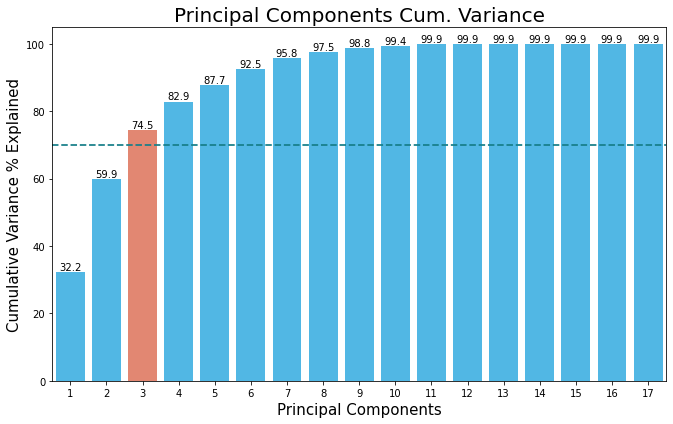

*********************************************************************************************************

Our 3 principal components:


array([[ 1.77067007, -0.06273376,  0.9067211 ],
       [ 0.41589738, -0.26556426,  0.26514403],
       [-0.21615943,  0.03967785,  0.48024651],
       ...,
       [ 0.35635928, -0.43661978, -0.60364831],
       [ 0.23867051, -0.37246686, -0.89085847],
       [ 1.35673523, -0.37143011, -0.30767482]])

In [17]:
# Now that we have our new dataset ready, we search the optimal number of principal components:

def pca_hw4(X, treshold = 70):
    
    # Part 1: Import the packages
    # --------------------------------------------------------------------------------------------------------------------------------------------

    from sklearn.decomposition import PCA                                                                                                        
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Part 2: We find the optimal number of components
    # --------------------------------------------------------------------------------------------------------------------------------------------

    n = len(X.axes[1]) # number of columns of X
    covar_matrix = PCA(n_components = n).fit(X)
  
    ## Variance explained for each of the principal components
    variance = covar_matrix.explained_variance_ratio_
    cumulative_var = np.cumsum( np.round(variance, decimals = 3) * 100 )

    ## Find the number of components you need to go over your treshold:
    num_components = len(cumulative_var) # default value
    for i in range(len(cumulative_var)):
        if cumulative_var[i] >= treshold:
            num_components = i+1
            break     

    # Part 3: Plot to find the number of principal components you need
    # --------------------------------------------------------------------------------------------------------------------------------------------

    tot_num_components = len(cumulative_var)
    
    x = [x for x in range(1, tot_num_components + 1)] # numbers from 1 to maximum number of components
    y = [var for var in cumulative_var] # value of the cumulative variance

    customized_col = ['#f57b5f' if c == num_components else '#38c1fc' for c in x]

    fig, ax = plt.subplots(figsize=(11, 6.5))

    ax.set_title('Principal Components Cum. Variance', fontsize = 20)
    ax.set_ylabel('Cumulative Variance % Explained', fontsize = 15)
    ax.set_xlabel('Principal Components', fontsize = 15)

    ax.axhline(treshold, color = '#177e89', linewidth = 1.75, linestyle = "--")

    sns.barplot(x, y, palette = customized_col) 
    ax.bar_label(ax.containers[0])
    plt.show()

    # Part 4: we perform the PCA with the chosen number of principal components
    # --------------------------------------------------------------------------------------------------------------------------------------------

    pca = PCA(n_components = num_components)
    principal_components = pca.fit_transform(X)

    # Part 5: Just the print of the dataframe containing the principal components
    # --------------------------------------------------------------------------------------------------------------------------------------------

    print('*' * 105)
    print('')
    print('Our', num_components, 'principal components:')

    return principal_components
    

pca = pca_hw4(X, treshold = 70)
pca

## 2.3: Clustering & K-means

### 2.3.1: K-Means from scratch

First, we define a function for the euclidean distance.
Thi is easy because we can just apply the basic formula you can find on wikipedia:

$$d(p, q) = \sqrt{\sum_{i = 1}^{n} (q_i - p_i)^2)}$$

In [1]:
def euclidean_dist(d, q):  #euclidean distance between two points
    return np.sqrt(np.sum((d - q) ** 2))

In [2]:
# I could not implement it with MapReduce.
# Inspired by: Patrick Loeber, https://www.youtube.com/@patloeber

class KMeans_HW4:
    
    ### PART 1

    def __init__(self, K = 4, n_max_iter = 75):
        
        # Very first thing to do: store the parameters
        self.K = K
        self.n_max_iter = n_max_iter

        # Now we want to define our clusters. We will start by creating "empty clusters". 
        # For each cluster, we want it to be a list containing the indices of the units which belong to it.
        # So we create a list of (empty) lists. We can do this with list comprehension:
        self.clusters = [[] for k in range(self.K)]
        
        # But we also need a place to store our centroids.
        # So, we set an empty list that will contain our centroids (aka: centers of the clusters)
        self.centroids = []


    ### PART 2

    # Usually, what you do at this point is defin a fit and a predict method (think for example at the logistic regression...).
    # But here we are dealing with an unsupervised-clustering-algorithm, that means we don't have any label in the dataset.
    # So, we just implement the predict method:
    def predict(self, X):
        self.X = X                                  # matrix of the data
        self.n_samples, self.n_features = X.shape   # number of rows and columns (because we need to use them later)

        # Here is where the real algorithm starts!
        # We have two main steps:
        # 1) The initialization: it is the phase where we initialize the centroids.
        #    In the standard KMeans, this is a random choice.
        #    In KMeans++, which we will use later, we try to choose centroids that are far apart through probabilistic statements. 
        # 2) The Optimization: it is where we update our clusters (so the centroids) based on the new data points we assign at each iteration.
        #    First, we use the centroids we already stored to assign the labels at the point
        #    Second, we compute again the centroids of each cluster
        #    Third, we assign again the labels...
        #    ... and so on
        
        
        ## 1) Initialization:
        rand_ind = np.random.choice(self.n_samples, self.K, replace=False)  # we randomly pick some indeces 
        #                                                                     (using a numpy built-in function)
        #                                                                     We set replace = False because we don't want
        #                                                                     to sample the same index more than once.

        # And we assign these (very first) centroids to our clusters:
        self.centroids = [self.X[index] for index in rand_ind]

        # This is as far as initialization is concerned.
        # Now let's move on to the second phase

        ## 2) Optimization:
        for iter in range(self.n_max_iter):  # --> here is where we say to stop after n_max_iter iterations
            # Assign samples to closest centroids (create clusters)
            self.clusters = self.create_clusters(self.centroids)# Function 1 (defined below)

            # Update centroids
            old_centroids = self.centroids # Here we are only cehcking if the old centroids have changed. We need this information for the convergence step
            self.centroids = self.get_centroids(self.clusters) # Function 3: defined below

            # We have seted the maximum number of iterations, but the hope is to find the partition before we reach it.
            # Therefore, at each iteration we check whether the new clusters are different from the previously defined ones:
            #   - if they are different, perhaps we can still improve them, so the algorithm continues.
            #   - if they are the same, the algorithm has reached its conclusion (and in fact we talk about "convergence").
            # Check for Convergence
            if self.convergence(old_centroids, self.centroids): # Function 4 (defined below)
                break

        # Finally, we classify samples as the index of their clusters
        return self.get_labels(self.clusters) # Function 5: defined below

    # Function 1: take an index and assign it to the closest cluster
    def create_clusters(self, centroids):
        # Here we assign the data-points to the clostest cluster
        clusters = [[] for _ in range(self.K)] # like before, we start from an empty list of lists
        for idx, sample in enumerate(self.X):
            centroid_idx = self._closest_centroid(sample, centroids) # Function 2: this function is defined further below
            clusters[centroid_idx].append(idx) # here we append the data-point index to the closest sample
        return clusters

    # Function 2: find the closest centroid (thinkking in terms of euclidean distance) for a given point
    def _closest_centroid(self, sample, centroids):
        # distance of the current sample to each centroid
        dist = [euclidean_dist(sample, point) for point in centroids] # we store all the distances
        # If we have 5 clusters, this will be a list containing 5 indexes, each one corresponding to a cluster
        closest_index = np.argmin(dist) # we find the minimum distance
        return closest_index # return the index of the closest cluster. 
    
    # Function 3: compute the mean of the clusters
    def get_centroids(self, clusters):
        # assign mean value of clusters to centroids
        centroids = np.zeros((self.K, self.n_features))
        for cluster_idx, cluster in enumerate(clusters):
            cluster_mean = np.mean(self.X[cluster], axis=0) # compute the mean of the cluster...
            centroids[cluster_idx] = cluster_mean # ... and then define the new centroid
        return centroids
    
    # Function 4: check if the new centroids are equal to the ones at the previous iteration
    def convergence(self, centroids_old, centroids):
        # distances between each old and new centroids, fol all centroids
        distances = [
            euclidean_dist(centroids_old[i], centroids[i]) for i in range(self.K)
        ]
        return sum(distances) == 0  # returns True/False. If True, there is no change in our centroids

    # Function 5: very last part, assign the labels to the data points
    def get_labels(self, clusters):
        # each sample will get the label of the cluster it was assigned to
        labels = np.empty(self.n_samples) # pre-alloc
        for cluster_idx, cluster in enumerate(clusters):
            for sample_index in cluster:
                labels[sample_index] = cluster_idx # each index is assigned to the corresponding cluster
        return labels

### 2.3.2: Find an optimal number of clusters

In [18]:
pca

array([[ 1.77067007, -0.06273376,  0.9067211 ],
       [ 0.41589738, -0.26556426,  0.26514403],
       [-0.21615943,  0.03967785,  0.48024651],
       ...,
       [ 0.35635928, -0.43661978, -0.60364831],
       [ 0.23867051, -0.37246686, -0.89085847],
       [ 1.35673523, -0.37143011, -0.30767482]])

In [4]:
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

First Method for the choice of the optimal number of clusters: Elbow Method

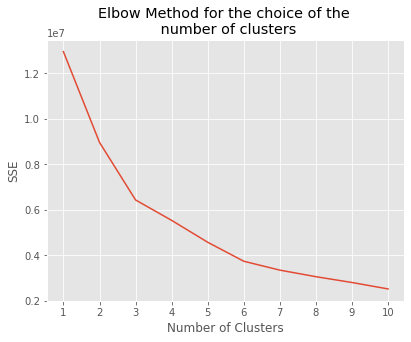

In [19]:
kmeans_kwargs = { "init": "random", "n_init": 10, "max_iter": 300, "random_state": 42}

sse = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pca)
    sse.append(kmeans.inertia_)

plt.style.use("ggplot")
plt.figure(figsize = [6.4, 4.8])
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title("Elbow Method for the choice of the \n number of clusters")
plt.show()

Second Method for the choice of the optimal number of clusters: Silhouette Score

The Silhouette method is usually used togheter with the Elbow Method for a more precise decision.
The Silhouette coefficient varies from -1 to +1: the closer it is to 1, the more accurate the cluster partitioning is.
The advantage of this procedure is that it makes the choice of the number of clusters k more graphically clear (there is no elbow to look for in the graph...) and more accurate, but it has a major drawback. 
In fact, in order to calculate this index, we need to calculate the coefficient for each of the possible values of k, and this substantially increases the computational complexity.

In [46]:
range_n_clusters = [2, 3, 4, 5, 6]
silhouette_avg = []
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters = num_clusters)
    kmeans.fit(pca)
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(pca[1:100000], cluster_labels[1:100000]))
    print(num_clusters, '... ... done')

2 ... ... done
3 ... ... done
4 ... ... done
5 ... ... done
6 ... ... done


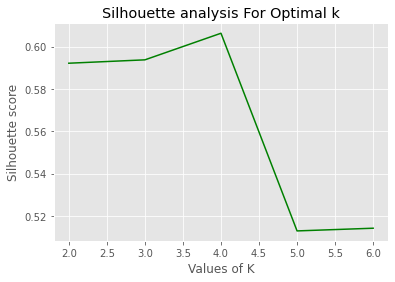

In [60]:
plt.plot(range_n_clusters, silhouette_avg, 'green')
plt.xlabel("Values of K") 
plt.ylabel("Silhouette score") 
plt.title("Silhouette analysis For Optimal k")
plt.show()

We note that the silhouette index recommends choosing a number of clusters equal to k.
However, it can be seen that the index calculated in k=3 and k=4 is very similar. In addition, we used a sample of only 100000 units (just over 10% of the total) to calculate this score.
Therefore, also to make the algorithm computationally lighter in the next step, we choose to adopt a number of clusters equal to 3.

### 2.3.3: Algorithm on the data

In [296]:
# Now that we know how many clusters we need, we assign the labels:

#Initialize the class object
kmeans = KMeans(n_clusters= 3) #, init = 'k-means++', random_state=42
 
labels = kmeans.fit_predict(pca)
np.unique(labels)

array([0, 1, 2], dtype=int32)

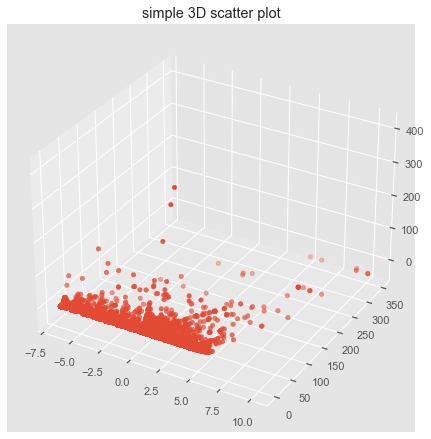

In [346]:
# Our points look like this:

pca_df = pd.DataFrame(pca)
pca_df = pca_df.set_axis(['1PC', '2PC', '3PC'], axis=1, inplace=False)

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection = "3d")
 
# Creating plot
ax.scatter3D(pca_df['1PC'], pca_df['2PC'], pca_df['3PC'])
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

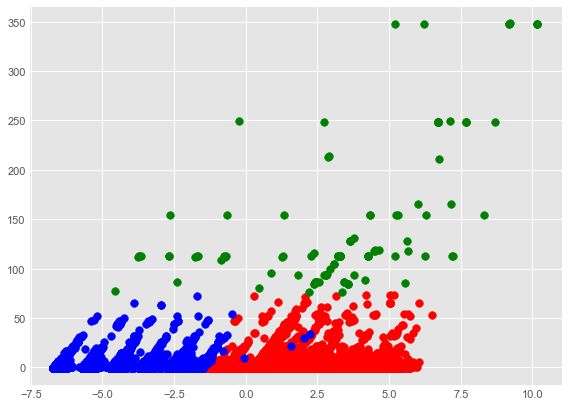

In [353]:
# Of course it's not easy to visualize almost 1 million points... se we will go for a 2D representation.

plt.figure(figsize=[8.5, 6.5])
plt.scatter(pca[labels==0, 0], pca[labels==0, 1], s=60, c='red')
plt.scatter(pca[labels==1, 0], pca[labels==1, 1], s=60, c='blue')
plt.scatter(pca[labels==2, 0], pca[labels==2, 1], s=60, c='green')

### 2.3.4: K-Means++

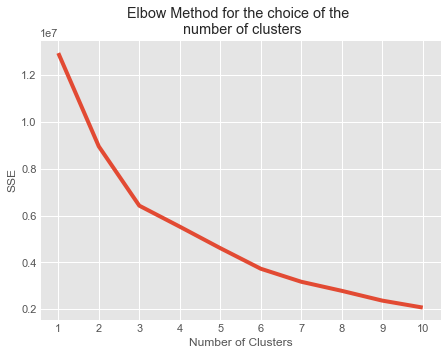

In [305]:
# Now we do the same thing using kmeans++

sse = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 42)
    kmeans.fit(pca)
    sse.append(kmeans.inertia_)

plt.style.use("ggplot")
plt.figure(figsize = [6.4, 4.8])
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title("Elbow Method for the choice of the \n number of clusters")
plt.show()

In [306]:
kmeans = KMeans(n_clusters= 3, init = 'k-means++', random_state = 42) #, init = 'k-means++', random_state=42
 
labels = kmeans.fit_predict(pca)
np.unique(labels)

array([0, 1, 2], dtype=int32)

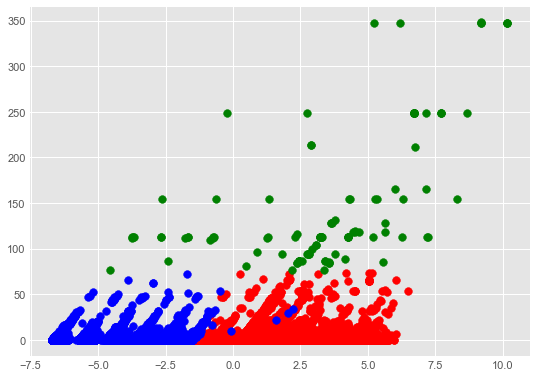

In [354]:
plt.figure(figsize=[8, 6])
plt.scatter(pca[labels==0, 0], pca[labels==0, 1], s=60, c='red')
plt.scatter(pca[labels==1, 0], pca[labels==1, 1], s=60, c='blue')
plt.scatter(pca[labels==2, 0], pca[labels==2, 1], s=60, c='green')

# We obtain exactly the same result

### 2.4 Analysing your results! (Features + Pivot Table)

### 2.4.1: Choice of the features

In [584]:
# Average_Balance  -> rich/poor
# Age_Status
# Average_Amount_Transactions
# Cust_Gender

# We have to categorise these variables. We perform this operation on the original variables, not the transformed ones.
# First, we create a copy of the dataset containing transformed variables:

data_small_2 = data_small.copy()

# Then we remove the +inf and -inf values, so that the lenght of this dataset will correspond to the lenght of the standardized dataset
data_small_2 = data_small_2.replace([np.inf, -np.inf], np.nan, inplace=False) 
data_small_2 = data_small_2.dropna()
#data_small_2.head()

# Now we select only the variables we are interested in:
data_small_2 = data_small_2[['Average_Balance', 'Age_Status', 'Average_Amount_Transactions', 'CustGender']]

# Notice: we will keep the Age_Status variable categorized in 3 gruops, not in 4, because otherwise there would be an imbalance due to a strong presence of people between 31 and 33 that would negatively impact the analysis 

# Finally we add the label of the cluster to each customer:
data_small_2['Label'] = labels

# A quick look
data_small_2.head()

,Average_Balance,Age_Status,Average_Amount_Transactions,CustGender,Label
0,76340.635,Young,2553.0,F,0
1,24204.490,Young,1499.0,M,0
2,100112.950,Young,727.5,F,0
3,496.180,Young,30.0,F,0
4,87058.650,Adult,5000.0,M,0


In [585]:
# Before we categorize, look at the following two tables:

display(
    data_small_2.pivot_table(index=['Label'], columns=['CustGender'], aggfunc='mean'),
    '*' * 75,
    '*' * 75,
    data_small_2.pivot_table(index=['Label'], columns=['Age_Status'], aggfunc='mean')
)

Average_Amount_Transactions               Average_Balance  \
CustGender                           F             M               F   
Label                                                                  
0                          1564.694922   1372.473722    9.795951e+04   
1                          1634.694483   1477.415967    8.630168e+04   
2                          3288.924844  14819.501165    5.584985e+07   

                          
CustGender             M  
Label                     
0           1.030088e+05  
1           9.390705e+04  
2           4.629187e+07

'***************************************************************************'

'***************************************************************************'

Average_Amount_Transactions                            \
Age_Status                       Adult      Elderly        Young   
Label                                                              
0                          1819.593895  3277.148738  1018.815350   
1                          1967.037295  3394.677068  1072.404139   
2                         19206.286232  6655.795833  4164.166667   

           Average_Balance                              
Age_Status           Adult       Elderly         Young  
Label                                                   
0             1.447471e+05  3.402137e+05  5.424615e+04  
1             1.375119e+05  3.304308e+05  4.418432e+04  
2             4.950065e+07  4.867478e+07  4.661847e+07

What immediately jumps out is that there does not seem to be a 'gender effect'.
The difference between the two variables (and thus also in the cluster division...) seems to depend more on age!
The older one gets, the larger the bank account grows, and consequently larger transactions can be made. For example, look at the difference in Average_Amount_Transactions between young and old, especially in the first two clusters: the ratio is almost 3:1!
Viceversa, this difference is not evident if we divide customers by gender. We conclude that the gender of clients is not a discriminating variable.

### 2.4.2, 2.4.3, 2.4.4, 2.4.5: Categorization & Pivot Tables

Now we have to categorise our variables. Age_status and Cust_Gender are already categorised, so we have to transform Average_balance and Average_Amount_Transactions.
We need to divide into 4 categories, and we want to balance the dimension of each class we are going to create, in order not to introduce some sort of bias --> 200k for each class

In [586]:
# Part 1: categorize Average_balance

data_small_2.loc[(data_small_2['Average_Balance'] >= 0) & (data_small_2['Average_Balance'] <= 5500) , 'Average_Balance'] = 1
data_small_2.loc[(data_small_2['Average_Balance'] > 5500) & (data_small_2['Average_Balance'] <= 18000), 'Average_Balance' ] = 2
data_small_2.loc[(data_small_2['Average_Balance'] > 18000) & (data_small_2['Average_Balance'] <= 60000), 'Average_Balance' ] = 3
data_small_2.loc[data_small_2['Average_Balance'] > 60000, 'Average_Balance'] = 4

data_small_2['Average_Balance'] = data_small_2['Average_Balance'].astype('int')

# Part 2: categorize Average_Amount_Transactions

data_small_2.loc[(data_small_2['Average_Amount_Transactions'] >= 0) & (data_small_2['Average_Amount_Transactions'] <= 175) , 'Average_Amount_Transactions'] = 1
data_small_2.loc[(data_small_2['Average_Amount_Transactions'] > 175) & (data_small_2['Average_Amount_Transactions'] <= 450), 'Average_Amount_Transactions' ] = 2
data_small_2.loc[(data_small_2['Average_Amount_Transactions'] > 450) & (data_small_2['Average_Amount_Transactions'] <= 1100), 'Average_Amount_Transactions' ] = 3
data_small_2.loc[data_small_2['Average_Amount_Transactions'] > 1100, 'Average_Amount_Transactions'] = 4

data_small_2['Average_Amount_Transactions'] = data_small_2['Average_Amount_Transactions'].astype('int')

# So we set 1 for low balances and low average transactions, 4 for the high values end the middle numbers for middle values

In [520]:
data_small_2.head(10)

,Average_Balance,Age_Status,Average_Amount_Transactions,CustGender,Label
0,4,Young,4,F,0
1,3,Young,4,M,0
2,4,Young,3,F,0
3,1,Young,1,F,0
4,4,Adult,4,M,0
5,4,Young,3,F,0
6,1,Adult,3,M,1
7,4,Young,2,M,0
8,4,Young,2,M,0
9,4,Adult,4,M,0


In [610]:
# We now turn to calculating percentages in pivot tables.

pivot_table_cluster = []
pivot_table_gender1 = []
pivot_table_gender2 = []

for cluster in np.unique(data_small_2.Label).tolist():
    pivot_table_cluster.append(cluster)
    pivot_table_cluster.append(cluster)
    for gender in np.unique(data_small_2.CustGender).tolist():
        pivot_table_gender1.append(len( data_small_2[(data_small_2['Label'] == cluster) & (data_small_2['CustGender'] == gender)] ))
        pivot_table_gender2.append(gender)
        print( 'In cluster', cluster, 'there are', len( data_small_2[(data_small_2['Label'] == cluster) & (data_small_2['CustGender'] == gender)] ), gender )
        
print(pivot_table_cluster)
print(pivot_table_gender1)
print(pivot_table_gender2)

In cluster 0 there are 199958 F
In cluster 0 there are 448909 M
In cluster 1 there are 53230 F
In cluster 1 there are 134862 M
In cluster 2 there are 32 F
In cluster 2 there are 83 M
[0, 0, 1, 1, 2, 2]
[199958, 448909, 53230, 134862, 32, 83]
['F', 'M', 'F', 'M', 'F', 'M']


In [640]:
n_0 = len( data_small_2[data_small_2['Label'] == 0] ) 
n_1 = len( data_small_2[data_small_2['Label'] == 1] ) 
n_2 = len( data_small_2[data_small_2['Label'] == 2] )

f_0 = len( data_small_2[ (data_small_2['Label'] == 0) & (data_small_2['CustGender'] == 'F') ] ) 
m_0 = len( data_small_2[ (data_small_2['Label'] == 0) & (data_small_2['CustGender'] == 'M') ] )
f_1 = len( data_small_2[ (data_small_2['Label'] == 1) & (data_small_2['CustGender'] == 'F') ] ) 
m_1 = len( data_small_2[ (data_small_2['Label'] == 1) & (data_small_2['CustGender'] == 'M') ] )
f_2 = len( data_small_2[ (data_small_2['Label'] == 2) & (data_small_2['CustGender'] == 'F') ] ) 
m_2 = len( data_small_2[ (data_small_2['Label'] == 2) & (data_small_2['CustGender'] == 'M') ] )

piv_t_gender = pd.DataFrame([ [f_0/n_0, m_0/n_0], [f_1/n_1, m_1/n_1], [f_2/n_2, m_2/n_2]]).set_axis(['F', 'M'], axis=1, inplace=False) * 100

##############################################################################################################################################

y_0 = len( data_small_2[ (data_small_2['Label'] == 0) & (data_small_2['Age_Status'] == 'Young') ] ) 
a_0 = len( data_small_2[ (data_small_2['Label'] == 0) & (data_small_2['Age_Status'] == 'Adult') ] )
e_0  = len( data_small_2[ (data_small_2['Label'] == 0) & (data_small_2['Age_Status'] == 'Elderly') ] )

y_1 = len( data_small_2[ (data_small_2['Label'] == 1) & (data_small_2['Age_Status'] == 'Young') ] ) 
a_1 = len( data_small_2[ (data_small_2['Label'] == 1) & (data_small_2['Age_Status'] == 'Adult') ] )
e_1  = len( data_small_2[ (data_small_2['Label'] == 1) & (data_small_2['Age_Status'] == 'Elderly') ] )

y_2 = len( data_small_2[ (data_small_2['Label'] == 2) & (data_small_2['Age_Status'] == 'Young') ] ) 
a_2 = len( data_small_2[ (data_small_2['Label'] == 2) & (data_small_2['Age_Status'] == 'Adult') ] )
e_2  = len( data_small_2[ (data_small_2['Label'] == 2) & (data_small_2['Age_Status'] == 'Elderly') ] )

piv_t_age = pd.DataFrame([ [y_0/n_0, a_0/n_0, e_0/n_0], [y_1/n_1, a_1/n_1, e_1/n_1], [y_2/n_2, a_2/n_2, e_2/n_2]]).set_axis(['Young', 'Adult', 'Elderly'], axis=1, inplace=False) * 100

###############################################################################################################################################

display(piv_t_gender, '*'*35, piv_t_age)


,F,M
0,30.816485,69.183515
1,28.299981,71.700019
2,27.826087,72.173913


'***********************************'

,Young,Adult,Elderly
0,51.653112,46.580732,1.766155
1,52.207962,46.253961,1.538077
2,2.608696,40.000000,57.391304


### 2.4.6: Metrics to estimate clustering algorithm performance